In [22]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/kc_house_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
data.shape

(21613, 21)

In [24]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [25]:
np.where(data['sqft_above'].isnull().values==True)

(array([10, 17]),)

In [26]:
data = data.drop([10, 17])
data = data.reset_index(drop=True)

In [27]:
data.shape

(21611, 21)

In [28]:
data = data.sample(frac=1, random_state = 42).reset_index(drop=True)
dataRaw = data.copy()

In [29]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [30]:
data = data.drop(['id', 'date'], axis=1)

In [31]:
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [32]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,570000.0,4,2.50,2640,11816,2.0,0,0,3,8,2640.0,0,1999,0,98019,47.7330,-121.968,2400,11816
1,720001.0,3,2.50,1430,2200,1.5,0,0,4,7,1430.0,0,1910,0,98103,47.6601,-122.331,1740,4275
2,267000.0,3,2.00,1390,6005,2.0,0,0,3,8,1390.0,0,2005,0,98022,47.2117,-121.990,1264,5550
3,320000.0,3,3.25,1450,1387,2.0,0,0,3,8,1180.0,270,2013,0,98106,47.5556,-122.362,1450,1198
4,397000.0,4,1.75,2020,6000,1.0,0,0,3,7,1620.0,400,1959,0,98144,47.5770,-122.302,1870,4000


In [33]:
type(data)

pandas.core.frame.DataFrame

In [34]:
X = data.drop('price', axis=1)
y = data['price']

In [35]:
data = data.values

In [36]:
type(data)

numpy.ndarray

In [37]:
#normalizando os dados de entrada
xdp = np.std(X)
xm = np.mean(X)
X = (X-xm)/xdp

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [38]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import torch   
from torch import Tensor             
import torch.nn as nn                    
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError
from sklearn.model_selection import KFold

In [40]:
for i, (train_index, test_index) in enumerate(KFold().split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 4323  4324  4325 ... 21608 21609 21610]
  Test:  index=[   0    1    2 ... 4320 4321 4322]
Fold 1:
  Train: index=[    0     1     2 ... 21608 21609 21610]
  Test:  index=[4323 4324 4325 ... 8642 8643 8644]
Fold 2:
  Train: index=[    0     1     2 ... 21608 21609 21610]
  Test:  index=[ 8645  8646  8647 ... 12964 12965 12966]
Fold 3:
  Train: index=[    0     1     2 ... 21608 21609 21610]
  Test:  index=[12967 12968 12969 ... 17286 17287 17288]
Fold 4:
  Train: index=[    0     1     2 ... 17286 17287 17288]
  Test:  index=[17289 17290 17291 ... 21608 21609 21610]


In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = torch.nn.Sequential(
    torch.nn.Linear(18, 18),
    nn.ReLU(),
    torch.nn.Linear(18, 18),
    nn.ReLU(),
    torch.nn.Linear(18, 5),
    nn.ReLU(),
    torch.nn.Linear(5, 1),
).to(device)
print(model)

loss_fn = MeanAbsolutePercentageError().to(device)
optimizer = optim.AdamW(model.parameters())


Using cpu device
Sequential(
  (0): Linear(in_features=18, out_features=18, bias=True)
  (1): ReLU()
  (2): Linear(in_features=18, out_features=18, bias=True)
  (3): ReLU()
  (4): Linear(in_features=18, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)


In [42]:
model.apply(reset_weights)
# Loop pelos folds
for fold, (train_index, val_index) in enumerate(KFold().split(X, y)):
    # Separar os dados em treino e teste
    X_train, y_train = X.loc[train_index,:].values, y.loc[train_index].values
    X_test, y_test = X.loc[val_index,:].values, y.loc[val_index].values

    X_train = torch.from_numpy(X_train).to(device)
    y_train = torch.from_numpy(y_train).to(device)
    X_test = torch.from_numpy(X_test).to(device)
    y_test = torch.from_numpy(y_test).to(device)

    # Treinar o modelo
    for epoch in range(25000):
        # Forward pass
        X_train = X_train.float()
        y_pred = model(X_train)
        # Calcular a perda
        loss = loss_fn(y_pred.squeeze(), y_train)

        # Backward pass e atualização dos pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimir a perda a cada 100 épocas
        if epoch % 100 == 0:
            print('Fold {}, Epoch {}, Loss: {}'.format(fold, epoch, loss.item()))

    #Testando
    X_test = X_test.float()
    print('Fold {}, Loss: {}'.format(fold, loss_fn(model(X_test).squeeze() ,y_test)))
    #Salvando o modelo
    torch.save(model.state_dict(), '/content/drive/MyDrive/IA Trabalho 2/FILIPE_DA_SILVA_ARAUJO_RNA_FOLD_{}.pth'.format(fold))
    torch.save(model.state_dict(), '/content/FILIPE_DA_SILVA_ARAUJO_RNA_FOLD_{}.pth'.format(fold))
    print('Fold {} saved'.format(fold))

    #Reiniciando o modelo para o próximo Fold
    model.apply(reset_weights)

Fold 0, Epoch 0, Loss: 0.9999996423721313
Fold 0, Epoch 100, Loss: 0.9999935626983643
Fold 0, Epoch 200, Loss: 0.9998530149459839
Fold 0, Epoch 300, Loss: 0.9989051222801208
Fold 0, Epoch 400, Loss: 0.9957883954048157
Fold 0, Epoch 500, Loss: 0.9885172843933105
Fold 0, Epoch 600, Loss: 0.9745205640792847
Fold 0, Epoch 700, Loss: 0.9507890939712524
Fold 0, Epoch 800, Loss: 0.9142712354660034
Fold 0, Epoch 900, Loss: 0.8635191917419434
Fold 0, Epoch 1000, Loss: 0.8022957444190979
Fold 0, Epoch 1100, Loss: 0.7426413893699646
Fold 0, Epoch 1200, Loss: 0.6959789395332336
Fold 0, Epoch 1300, Loss: 0.6598834991455078
Fold 0, Epoch 1400, Loss: 0.6279909610748291
Fold 0, Epoch 1500, Loss: 0.5966617465019226
Fold 0, Epoch 1600, Loss: 0.5654200315475464
Fold 0, Epoch 1700, Loss: 0.537197470664978
Fold 0, Epoch 1800, Loss: 0.5156708359718323
Fold 0, Epoch 1900, Loss: 0.4989328980445862
Fold 0, Epoch 2000, Loss: 0.4845619797706604
Fold 0, Epoch 2100, Loss: 0.47211864590644836
Fold 0, Epoch 2200, Lo

In [43]:
predicted_prices = []
for fold, (train_index, val_index) in enumerate(KFold().split(X, y)):
    X_test, y_test = X.loc[val_index,:].values, y.loc[val_index].values
    X_test = torch.from_numpy(X_test).to(device)
    y_test = torch.from_numpy(y_test).to(device)

    model.load_state_dict(torch.load("/content/drive/MyDrive/IA Trabalho 2/FILIPE_DA_SILVA_ARAUJO_RNA_FOLD_{}.pth".format(fold)))

    X_test = X_test.float()
    model.eval()
    with torch.no_grad():
        pred = model(X_test)

    pred = pred.detach().cpu().numpy().squeeze()
    predicted_prices.append(pred)

In [44]:
predicted_prices = pd.DataFrame(predicted_prices)

In [45]:
predicted_prices = pd.concat([predicted_prices.loc[0], predicted_prices.loc[1], predicted_prices.loc[2], predicted_prices.loc[3], predicted_prices.loc[4]], axis=0)

In [46]:
predicted_prices

0       481163.93750
1       612985.37500
2       238744.90625
3       400618.46875
4       460096.81250
            ...     
4318    539989.00000
4319    502355.03125
4320    463161.03125
4321    320288.31250
4322             NaN
Length: 21615, dtype: float64

In [47]:
predicted_prices = predicted_prices.squeeze()

In [48]:
predicted_prices

0       481163.93750
1       612985.37500
2       238744.90625
3       400618.46875
4       460096.81250
            ...     
4318    539989.00000
4319    502355.03125
4320    463161.03125
4321    320288.31250
4322             NaN
Length: 21615, dtype: float64

In [49]:
predicted_prices.reset_index(drop=True)

0        481163.93750
1        612985.37500
2        238744.90625
3        400618.46875
4        460096.81250
             ...     
21610    539989.00000
21611    502355.03125
21612    463161.03125
21613    320288.31250
21614             NaN
Length: 21615, dtype: float64

In [50]:
predicted_prices.isnull().sum()

4

In [51]:
np.where(predicted_prices.isnull().values==True)

(array([ 8645, 12968, 17291, 21614]),)

In [52]:
type(predicted_prices)

pandas.core.series.Series

In [53]:
predicted_prices = predicted_prices.values.tolist()

In [54]:
type(predicted_prices)

list

In [55]:
del predicted_prices[8645]
del predicted_prices[12968]
del predicted_prices[12968]
del predicted_prices[12968]

In [56]:
print(len(predicted_prices))

21611


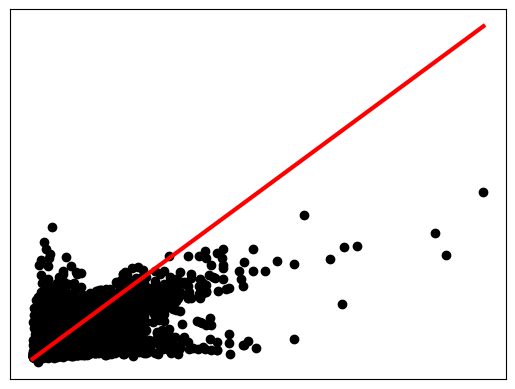

In [57]:
import matplotlib.pyplot as plt
plt.scatter(y, predicted_prices, color='black', )
plt.plot(np.arange(np.min(y), np.max(y)), np.arange(np.min(y), np.max(y)), color="red", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [58]:
heat = abs(np.divide(predicted_prices-y, y))
heatM = []

In [59]:
import folium
m = folium.Map(location=[47.605687, -122.328773], zoom_start=8)

In [60]:
pophtml = """
<b>Price:</b> {}<br>
<b>Predicted Price:</b> {}<br>
<b>Bedrooms:</b> {}<br>
<b>Bathrooms:</b> {}<br>
<b>Sqft living:</b> {}<br>
<b>Sqft lot:</b> {}<br>
<b>Floors:</b> {}<br>
<b>Waterfront:</b> {}<br>
<b>View:</b> {}<br>
<b>Condition:</b> {}<br>
<b>Grade:</b> {}<br>
<b>Sqft above:</b> {}<br>
<b>Sqft basement:</b> {}<br>
<b>Year built:</b> {}<br>
<b>Year renovated:</b> {}<br>
<b>Zipcode:</b> {}<br>
<b>Latitude:</b> {}<br>
<b>Longitude:</b> {}<br>
<b>Sqft living15:</b> {}<br>
<b>Sqft lot15:</b> {}
"""

popup_html = []
for i in range(21611):
  popup_html.append(pophtml.format(dataRaw.loc[i, 'price'], predicted_prices[i], dataRaw.loc[i, 'bedrooms'], dataRaw.loc[i, 'bathrooms'], dataRaw.loc[i, 'sqft_living'], dataRaw.loc[i, 'sqft_lot'], dataRaw.loc[i, 'floors'], dataRaw.loc[i, 'waterfront'], dataRaw.loc[i, 'view'], 
                                dataRaw.loc[i, 'condition'], dataRaw.loc[i, 'grade'], dataRaw.loc[i, 'sqft_above'], dataRaw.loc[i, 'sqft_basement'], dataRaw.loc[i, 'yr_built'], dataRaw.loc[i, 'yr_renovated'], dataRaw.loc[i, 'zipcode'], 
                                dataRaw.loc[i, 'lat'], dataRaw.loc[i, 'long'], dataRaw.loc[i, 'sqft_living15'], dataRaw.loc[i, 'sqft_lot15']))
  
  hp = [dataRaw.loc[i, 'lat'], dataRaw.loc[i, 'long'], heat[i]]
  heatM.append(hp)

In [61]:
heatM = pd.DataFrame(heatM)

In [62]:
np.where(heatM.isnull().values==True)

(array([12967, 17287, 21610]), array([2, 2, 2]))

In [63]:
heatM = heatM.drop(np.where(heatM.isnull().values==True)[0])
heatM = heatM.drop(np.where(heatM.isnull().values==True)[1])

In [64]:
from folium.plugins import MarkerCluster
cluster_marcadores = MarkerCluster().add_to(m)

for i in range(21611):
    folium.Marker(location=[dataRaw.loc[i, 'lat'], dataRaw.loc[i, 'long']], popup=popup_html[i]).add_to(cluster_marcadores)

In [65]:
from folium.plugins import HeatMap
HeatMap(heatM, min_opacity=0, blur = 40,gradient = {0.2: 'red', 0.4: 'lime', 0.6: 'blue'}).add_to(m)

In [66]:
m.save('/content/map.html')
m.save('/content/drive/MyDrive/IA Trabalho 2/map.html')